In [1]:
import logging
import logging.handlers

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.DEBUG, format='[%(asctime)s]: %(levelname)s: %(message)s')

In [2]:
from sklearn.metrics import precision_recall_fscore_support as prf
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn import preprocessing
from sklearn.metrics import auc, roc_curve
import pandas as pd
import numpy as np
import csv
import pickle

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
dxpr_path_dir = '../tests/feature_selection/'

## Load Variable Names

In [5]:
def load_names(pickle_file):
    with open(pickle_file, 'rb') as f:
        names = pickle.load(f)
        names.remove('NDX') # since number of diagnoses/procedures are often assigned weeks and even months after discharge, these numbers might not be available in time for early prediction model to use them
        names.remove('NPR')
        names.remove('NCHRONIC')

    return names

In [6]:
names = load_names('../saved_models/input_variables.pkl')

## Load Data

In [7]:
input_path = "../../../data/hcup/nis/all_year_combination/cleaned_for_repcv_imputed.pickle"

In [8]:
def load_data_full(datafile, names, rescale = True):

    fn_pt_trn = pd.read_pickle(datafile)

    logger.info(list(fn_pt_trn.columns))

    fn_pt_trn.dropna(subset = ['DIED'], inplace = True)

    input_df_trn = fn_pt_trn[names]

    input_x_trn = input_df_trn.convert_objects(convert_numeric=True)
    input_y_died_trn = [int(x) for x in list(fn_pt_trn.DIED)]

    if rescale:
        scaler = preprocessing.StandardScaler().fit(input_x_trn)
        input_x_trn = scaler.transform(input_x_trn)
    X = input_x_trn
    y = input_y_died_trn
    y = np.asarray(y)

    return X, y

In [9]:
x, y = load_data_full(input_path, names)

[2020-03-06 11:51:05,275]: INFO: ['CCI', 'AGE', 'FEMALE', 'RACE_1', 'RACE_2', 'RACE_3', 'RACE_4', 'RACE_5', 'RACE_6', 'PAY1_1', 'PAY1_2', 'PAY1_3', 'PAY1_4', 'PAY1_5', 'PAY1_6', 'ZIPINC_QRTL_1', 'ZIPINC_QRTL_2', 'ZIPINC_QRTL_3', 'ZIPINC_QRTL_4', 'PL_NCHS', 'ASEASON_SPRING', 'ASEASON_SUMMER', 'ASEASON_FALL', 'ASEASON_WINTER', 'YEAR_2007', 'YEAR_2008', 'YEAR_2009', 'YEAR_2010', 'YEAR_2011', 'YEAR_2012', 'YEAR_2013', 'YEAR_2014', 'YEAR_2015', 'AWEEKEND', 'ELECTIVE', 'TOTAL_DISC', 'HOSP_BEDSIZE', 'HOSP_REGION_1', 'HOSP_REGION_2', 'HOSP_REGION_3', 'HOSP_REGION_4', 'H_CONTRL_1', 'H_CONTRL_2', 'H_CONTRL_3', 'HOSP_LOCTEACH_1', 'HOSP_LOCTEACH_2', 'HOSP_LOCTEACH_3', 'HCUP_ED_0', 'HCUP_ED_1', 'HCUP_ED_2', 'HCUP_ED_3', 'HCUP_ED_4', 'NDX', 'NPR', 'NCHRONIC', 'DXCCS_131', 'DXCCS_249', 'DXCCS_107', 'DXCCS_157', 'DXCCS_2', 'DXCCS_122', 'DXCCS_257', 'DXCCS_59', 'DXCCS_259', 'DXCCS_244', 'PRCCS_216', 'PRCCS_225', 'PRCCS_54', 'PRCCS_222', 'PRCCS_224', 'PRCCS_37', 'PRCCS_65', 'PRCCS_223', 'PRCCS_231', 'PR

## Train/Test (70%/30%) Split

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=None, stratify = y, shuffle = True)

In [12]:
train_x = np.array(train_x)
test_x = np.array(test_x)

In [13]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(88209, 82)
(88209,)
(37804, 82)
(37804,)


## Machine Learning Models Development

In [22]:
from sklearn.metrics import precision_recall_fscore_support as prf
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import roc_curve, auc, log_loss, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

In [15]:
# find the best cutoff point based on Youden's Index
def find_best_threshold(fpr, tpr, thresholds):

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    return optimal_threshold

In [16]:
# Model evaluation with fitted model and data used for evaluation. It returns all commonly used evaluation scores.
def evaluation_scores(fitted_model, x_test, y_test, mimic = False, mode = 'macro'):

    y_true = y_test

    # whether use mimic learning or not.
    if mimic == False:
        y_pred_prob = fitted_model.predict_proba(x_test)
    else:
        y_pred_prob = sigmoid(fitted_model.predict(x_test))
        y_pred_prob = np.stack((1-y_pred_prob, y_pred_prob), axis = -1)

    loss = log_loss(y_true, y_pred_prob)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:,1])

    # get performance based on the best cutoff defined by Youden's J Index
    optimal_threshold = find_best_threshold(fpr, tpr, thresholds)
    y_pred = y_pred_prob[:,1] >= optimal_threshold
    y_pred_prf = y_pred_prob[:,1] >= 0.5
    y_pred = y_pred.astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision, recall, f_score, _ = prf(y_true = y_true, y_pred = y_pred_prf, average = mode)
    sensitivity = tp/(tp + fn)
    specificity = tn/(tn + fp)
    roc_auc = auc(fpr, tpr)
    ppv = tp/(tp + fp)
    accuracy = acc(y_true = y_true, y_pred = y_pred)

    return fpr, tpr, tn, fp, fn, tp, precision, recall, f_score, sensitivity, specificity, roc_auc, ppv, accuracy, loss, optimal_threshold   

### Ridge Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
tuned_parameters_lr = {"C": [0.001, 0.01, 0.1, 1, 100, 1000]}

In [39]:
lr_clf = LogisticRegression(penalty = 'l2')

In [40]:
gs_lr = GridSearchCV(lr_clf, tuned_parameters_lr, cv = 3, scoring = 'roc_auc')

In [41]:
gs_lr.fit(train_x, train_y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [42]:
gs_lr.best_params_

{'C': 0.01}

In [43]:
fpr_lr, tpr_lr, tn_lr, fp_lr, fn_lr, tp_lr, precision_lr, recall_lr, f_score_lr, sensitivity_lr, specificity_lr, roc_auc_lr, ppv_lr, accuracy_lr, loss_lr, optimal_threshold_lr = evaluation_scores(gs_lr, test_x, test_y)

In [97]:
logger.info('precision: %.4f; recall: %4f; f_score: %4f; sensitivity: %4f; specificity: %4f; AUROC: %4f; optimal cutoff: %.4f'
            %(precision_lr, recall_lr, f_score_lr, sensitivity_lr, specificity_lr, roc_auc_lr, optimal_threshold_lr))

[2020-03-06 22:22:56,818]: INFO: precision: 0.8377; recall: 0.692619; f_score: 0.743070; sensitivity: 0.806488; specificity: 0.882182; AUROC: 0.918798; optimal cutoff: 0.0539


### Gradient Boosting Tree

In [45]:
from sklearn.ensemble import GradientBoostingClassifier

In [46]:
gbdt_clf = GradientBoostingClassifier()

In [47]:
tuned_parameters_gbdt = {"n_estimators": [100, 200, 300, 400, 500]}

In [48]:
gs_gbdt = GridSearchCV(gbdt_clf, tuned_parameters_gbdt, cv = 3, scoring = 'roc_auc')

In [49]:
gs_gbdt.fit(train_x, train_y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 200, 300, 400, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [50]:
gs_gbdt.best_params_

{'n_estimators': 200}

In [51]:
fpr_gbdt, tpr_gbdt, tn_gbdt, fp_gbdt, fn_gbdt, tp_gbdt, precision_gbdt, recall_gbdt, f_score_gbdt, sensitivity_gbdt, specificity_gbdt, roc_auc_gbdt, ppv_gbdt, accuracy_gbdt, loss_gbdt, optimal_threshold_gbdt = evaluation_scores(gs_gbdt, test_x, test_y)

In [52]:
logger.info('precision: %.4f; recall: %.4f; f_score: %.4f; sensitivity: %.4f; specificity: %.4f; AUROC: %.4f; optimal cutoff: %.4f'
            %(precision_gbdt, recall_gbdt, f_score_gbdt, sensitivity_gbdt, specificity_gbdt, roc_auc_gbdt, optimal_threshold_gbdt))

[2020-03-06 13:32:12,606]: INFO: precision: 0.8356; recall: 0.7009; f_score: 0.7494; sensitivity: 0.8099; specificity: 0.8865; AUROC: 0.9249; optimal cutoff: 0.0442


### Neural Network

In [53]:
import tensorflow as tf
import random

In [54]:
# Get validation set for parameter tuning
learn_x, val_x, learn_y, val_y = train_test_split(train_x, train_y, test_size=0.3, random_state=None, stratify = train_y, shuffle = True)

In [55]:
def batch_generator(batch_size, batch_index, input_x, input_y):
    input_x = np.array(input_x)
    input_y = np.array(input_y)
    if (batch_index+1)*batch_size < len(input_x):
        return input_x[batch_index*batch_size: (batch_index+1)*batch_size], input_y[batch_index*batch_size: (batch_index+1)*batch_size]
    else:
        select = random.sample(range(batch_index * batch_size), (batch_index+1)*batch_size - len(input_x))
        return np.concatenate([input_x[batch_index*batch_size: len(input_x)], input_x[select]]), np.concatenate([input_y[batch_index*batch_size: len(input_y)], input_y[select]]) 

In [56]:
config = tf.ConfigProto() 
config.gpu_options.allow_growth = True

In [57]:
class Model():
    pass

In [58]:
def declare_placeholders(self):
    self.input_batch = tf.placeholder(dtype=tf.float32, shape=[None, 82], name='input_batch')
    self.ground_truth_labels = tf.placeholder(dtype=tf.int32, shape=[None, None], name='ground_truth_labels')
    
#    self.lengths = tf.placeholder(dtype=tf.int32, shape=[None], name='lengths')
    self.dropout_ph = tf.placeholder_with_default(tf.cast(0.5, tf.float32), shape=[], name = 'dropout_ph')
    
    self.learning_rate_ph = tf.placeholder(dtype=tf.float32, shape=[], name='learning_rate_ph')
    self.temperature = tf.placeholder(dtype=tf.float32, shape=[], name='softmax_temperature')

In [59]:
Model.__declare_placeholders = classmethod(declare_placeholders)

In [60]:
def build_layers(self, n_hidden):
    self.layer_1 = tf.layers.dense(inputs = self.input_batch, units = n_hidden, activation = tf.nn.relu)
    self.bn_1 = tf.layers.batch_normalization(inputs = self.layer_1)
    self.layer_2 = tf.layers.dense(inputs = self.bn_1, units = n_hidden, activation = tf.nn.relu)
    self.bn_2 = tf.layers.batch_normalization(inputs = self.layer_2)
    self.layer_3 = tf.layers.dense(inputs = self.bn_2, units = n_hidden, activation = tf.nn.relu)
    self.bn_3 = tf.layers.batch_normalization(inputs = self.layer_3)
    self.layer_4 = tf.layers.dense(inputs = self.bn_3, units = n_hidden, activation = tf.nn.relu)
    self.bn_4 = tf.layers.batch_normalization(inputs = self.layer_4)    
    self.layer_5 = tf.layers.dense(inputs = self.bn_4, units = n_hidden, activation = tf.nn.relu)
    self.bn_5 = tf.layers.batch_normalization(inputs = self.layer_5)
    self.layer_6 = tf.layers.dense(inputs = self.bn_5, units = n_hidden, activation = tf.nn.relu)
    self.dropout_6 = tf.layers.dropout(self.layer_6, rate = self.dropout_ph)
    self.logits = tf.layers.dense(self.dropout_6, 2, activation=None)

In [61]:
Model.__build_layers = classmethod(build_layers)

In [62]:
def compute_predictions(self):
    self.softmax_output = tf.nn.softmax(logits = self.logits/self.temperature)
    self.predictions = tf.argmax(input = self.softmax_output, axis = -1)

In [63]:
Model.__compute_predictions = classmethod(compute_predictions)

In [64]:
def compute_loss(self):
    ground_truth_labels_one_hot = tf.one_hot(self.ground_truth_labels, 2)
#    self.loss_tensor = focal_loss(y_true = ground_truth_labels_one_hot, y_pred = self.logits)
#    self.loss_tensor = focal_loss(onehot_labels = ground_truth_labels_one_hot, cls_preds = self.logits)
    self.loss_tensor = tf.nn.softmax_cross_entropy_with_logits(labels = ground_truth_labels_one_hot, logits = self.logits)
    
#    mask = tf.cast(tf.not_equal(self.input_batch, PAD_index), tf.float32)
    self.loss = tf.reduce_mean(self.loss_tensor)

In [65]:
Model.__compute_loss = classmethod(compute_loss)

In [66]:
def perform_optimization(self):
    self.optimizer = tf.train.AdamOptimizer(learning_rate = self.learning_rate_ph)
    self.grads_and_vars = self.optimizer.compute_gradients(self.loss)
    clip_norm = tf.cast(1.0, tf.float32)
    self.grads_and_vars_2 = [(tf.clip_by_norm(grad, clip_norm), var) for grad, var in self.grads_and_vars]
    self.train_op = self.optimizer.apply_gradients(self.grads_and_vars_2)

In [67]:
Model.__perform_optimization = classmethod(perform_optimization)

In [68]:
def init_model(self, n_hidden):
    self.__declare_placeholders()
    self.__build_layers(n_hidden)
    self.__compute_predictions()
    self.__compute_loss()
    self.__perform_optimization()

In [69]:
Model.__init__ = classmethod(init_model)

In [70]:
def train_on_batch(self, session, x_batch, y_batch, learning_rate, dropout_keep_probability, temperature):
    feed_dict = {self.input_batch: x_batch,
                 self.ground_truth_labels: y_batch,
                 self.learning_rate_ph: learning_rate,
                 self.dropout_ph: dropout_keep_probability,
                 self.temperature: temperature}
    
    session.run(self.train_op, feed_dict=feed_dict)

In [71]:
Model.train_on_batch = classmethod(train_on_batch)

In [72]:
def predict_for_batch(self, session, x_batch, temperature):#, lengths):
    
    feed_dict = {self.input_batch: x_batch, self.temperature: temperature}#), self.lengths: lengths}
    predictions_proba = session.run(self.softmax_output, feed_dict = feed_dict)
    predictions = session.run(self.predictions, feed_dict = feed_dict)
    return predictions_proba, predictions

In [73]:
Model.predict_for_batch = classmethod(predict_for_batch)

In [74]:
tf.reset_default_graph()
model = Model(n_hidden = 512)

[2020-03-06 13:32:18,785]: WARNING: From <ipython-input-64-57c1e5c7e7b4>:5: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

[2020-03-06 13:32:19,447]: WARNING: From /apps/python3/3.6.5/lib/python3.6/site-packages/tensorflow/python/ops/clip_ops.py:110: calling reduce_sum (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


#### Parameter Tuning

In [75]:
import math
batch_size = 256
n_epochs = 32
learning_rate = 1e-5
#learning_rate_decay = 1.2
dropout_keep_probability = 0.5
temperature = 4
n_batches = math.ceil(len(learn_x)//batch_size)

In [76]:
def evaluation(model, session, data, label, temperature):
    from sklearn.metrics import precision_recall_fscore_support as prf
    from sklearn.metrics import auc, roc_curve
    y_pred_prob, y_pred = model.predict_for_batch(sess, data, temperature)
#    print(y_pred_prob[0:2])
#    print(y_pred[0:2])
    y_true = label
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:,1])
    # get performance based on the best cutoff defined by Youden's J Index
    optimal_threshold = find_best_threshold(fpr, tpr, thresholds)
    y_pred = y_pred_prob[:,1] >= optimal_threshold
    y_pred_prf = y_pred_prob[:,1] >= 0.5
    y_pred = y_pred.astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision, recall, f_score, _ = prf(y_true = y_true, y_pred = y_pred_prf, average = 'macro')
    sensitivity = tp/(tp + fn)
    specificity = tn/(tn + fp)
    roc_auc = auc(fpr, tpr)
    ppv = tp/(tp + fp)
    accuracy = acc(y_true = y_true, y_pred = y_pred)
    logger.info('precision: %.4f; recall: %.4f; f_score: %.4f; sensitivity: %.4f; specificity: %.4f; AUROC: %.4f; optimal cutoff: %.4f'
            %(precision, recall, f_score, sensitivity, specificity, roc_auc, optimal_threshold))
    return y_pred_prob, y_pred, roc_auc, fpr, tpr

In [78]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# early stop with a patience of 5
baseline = 0
patience = 3

print('Start training... \n')
for epoch in range(n_epochs):
    # For each epoch evaluate the model on train and validation data
    print('-' * 20 + ' Epoch {} '.format(epoch+1) + 'of {} '.format(n_epochs) + '-' * 20)
    print('Train data evaluation:')
    evaluation(model, sess, learn_x, learn_y, temperature)
    print('Validation data evaluation:')
    _, _, score, _, _ = evaluation(model, sess, val_x, val_y, temperature)
    if score > baseline:
        baseline = score
    else:
        patience -= 1
    if patience <= 0:
        break
    
    # Train the model
    for batch_index in range(n_batches):
        print(batch_index/n_batches,end="\r")
        dt = batch_generator(batch_size, batch_index, learn_x, learn_y)
        feed_dict = {model.input_batch: dt[0],
                 model.ground_truth_labels: dt[1].reshape(batch_size,1),
                 model.learning_rate_ph: learning_rate,
                 model.dropout_ph: dropout_keep_probability}
        model.train_on_batch(sess, dt[0], dt[1].reshape(batch_size, 1), learning_rate, dropout_keep_probability, temperature)
        
    # Decaying the learning rate
#    learning_rate = learning_rate / learning_rate_decay
#    break
    
print('...training finished.')

Start training... 

-------------------- Epoch 1 of 32 --------------------
Train data evaluation:


[2020-03-06 14:47:12,368]: INFO: precision: 0.4768; recall: 0.4998; f_score: 0.4880; sensitivity: 1.0000; specificity: 0.0001; AUROC: 0.2574; optimal cutoff: 0.4364


Validation data evaluation:


[2020-03-06 14:47:17,216]: INFO: precision: 0.4767; recall: 0.4998; f_score: 0.4880; sensitivity: 1.0000; specificity: 0.0001; AUROC: 0.2639; optimal cutoff: 0.4401


-------------------- Epoch 2 of 32 --------------------
Train data evaluation:


[2020-03-06 14:48:12,084]: INFO: precision: 0.4768; recall: 0.5000; f_score: 0.4881; sensitivity: 0.4653; specificity: 0.8447; AUROC: 0.6622; optimal cutoff: 0.3479


Validation data evaluation:


[2020-03-06 14:48:17,147]: INFO: precision: 0.4768; recall: 0.5000; f_score: 0.4881; sensitivity: 0.4268; specificity: 0.8780; AUROC: 0.6573; optimal cutoff: 0.3513


-------------------- Epoch 3 of 32 --------------------
Train data evaluation:


[2020-03-06 14:49:11,577]: INFO: precision: 0.8169; recall: 0.6831; f_score: 0.7299; sensitivity: 0.7466; specificity: 0.8831; AUROC: 0.8889; optimal cutoff: 0.3351


Validation data evaluation:


[2020-03-06 14:49:16,360]: INFO: precision: 0.7972; recall: 0.6736; f_score: 0.7172; sensitivity: 0.7675; specificity: 0.8755; AUROC: 0.8950; optimal cutoff: 0.3333


-------------------- Epoch 4 of 32 --------------------
Train data evaluation:


[2020-03-06 14:50:10,621]: INFO: precision: 0.8220; recall: 0.6958; f_score: 0.7417; sensitivity: 0.8167; specificity: 0.8385; AUROC: 0.9070; optimal cutoff: 0.3149


Validation data evaluation:


[2020-03-06 14:50:15,608]: INFO: precision: 0.8015; recall: 0.6856; f_score: 0.7281; sensitivity: 0.7870; specificity: 0.8704; AUROC: 0.9083; optimal cutoff: 0.3288


-------------------- Epoch 5 of 32 --------------------
Train data evaluation:


[2020-03-06 14:51:10,554]: INFO: precision: 0.8284; recall: 0.6959; f_score: 0.7435; sensitivity: 0.8215; specificity: 0.8496; AUROC: 0.9144; optimal cutoff: 0.3180


Validation data evaluation:


[2020-03-06 14:51:15,616]: INFO: precision: 0.8032; recall: 0.6857; f_score: 0.7286; sensitivity: 0.8236; specificity: 0.8440; AUROC: 0.9127; optimal cutoff: 0.3171


-------------------- Epoch 6 of 32 --------------------
Train data evaluation:


[2020-03-06 14:52:09,286]: INFO: precision: 0.8339; recall: 0.6982; f_score: 0.7468; sensitivity: 0.8156; specificity: 0.8655; AUROC: 0.9191; optimal cutoff: 0.3246


Validation data evaluation:


[2020-03-06 14:52:14,315]: INFO: precision: 0.8042; recall: 0.6846; f_score: 0.7279; sensitivity: 0.8211; specificity: 0.8523; AUROC: 0.9149; optimal cutoff: 0.3207


-------------------- Epoch 7 of 32 --------------------
Train data evaluation:


[2020-03-06 14:53:08,617]: INFO: precision: 0.8347; recall: 0.6999; f_score: 0.7484; sensitivity: 0.8093; specificity: 0.8778; AUROC: 0.9228; optimal cutoff: 0.3306


Validation data evaluation:


[2020-03-06 14:53:13,798]: INFO: precision: 0.8047; recall: 0.6854; f_score: 0.7287; sensitivity: 0.8089; specificity: 0.8691; AUROC: 0.9161; optimal cutoff: 0.3289


-------------------- Epoch 8 of 32 --------------------
Train data evaluation:


[2020-03-06 14:54:08,001]: INFO: precision: 0.8383; recall: 0.7028; f_score: 0.7517; sensitivity: 0.8310; specificity: 0.8610; AUROC: 0.9260; optimal cutoff: 0.3223


Validation data evaluation:


[2020-03-06 14:54:13,193]: INFO: precision: 0.8064; recall: 0.6875; f_score: 0.7308; sensitivity: 0.8179; specificity: 0.8602; AUROC: 0.9169; optimal cutoff: 0.3249


-------------------- Epoch 9 of 32 --------------------
Train data evaluation:


[2020-03-06 14:55:08,319]: INFO: precision: 0.8405; recall: 0.7043; f_score: 0.7534; sensitivity: 0.8285; specificity: 0.8697; AUROC: 0.9289; optimal cutoff: 0.3262


Validation data evaluation:


[2020-03-06 14:55:13,640]: INFO: precision: 0.8048; recall: 0.6862; f_score: 0.7294; sensitivity: 0.8146; specificity: 0.8648; AUROC: 0.9175; optimal cutoff: 0.3268


-------------------- Epoch 10 of 32 --------------------
Train data evaluation:


[2020-03-06 14:56:09,015]: INFO: precision: 0.8423; recall: 0.7072; f_score: 0.7563; sensitivity: 0.8609; specificity: 0.8460; AUROC: 0.9316; optimal cutoff: 0.3154


Validation data evaluation:


[2020-03-06 14:56:14,558]: INFO: precision: 0.8051; recall: 0.6874; f_score: 0.7304; sensitivity: 0.8114; specificity: 0.8676; AUROC: 0.9178; optimal cutoff: 0.3282


-------------------- Epoch 11 of 32 --------------------
Train data evaluation:


[2020-03-06 14:57:09,634]: INFO: precision: 0.8450; recall: 0.7096; f_score: 0.7589; sensitivity: 0.8599; specificity: 0.8546; AUROC: 0.9342; optimal cutoff: 0.3188


Validation data evaluation:


[2020-03-06 14:57:14,898]: INFO: precision: 0.8048; recall: 0.6882; f_score: 0.7310; sensitivity: 0.8049; specificity: 0.8723; AUROC: 0.9179; optimal cutoff: 0.3304


-------------------- Epoch 12 of 32 --------------------
Train data evaluation:


[2020-03-06 14:58:12,142]: INFO: precision: 0.8461; recall: 0.7120; f_score: 0.7611; sensitivity: 0.8578; specificity: 0.8643; AUROC: 0.9367; optimal cutoff: 0.3229


Validation data evaluation:


[2020-03-06 14:58:17,511]: INFO: precision: 0.8022; recall: 0.6880; f_score: 0.7302; sensitivity: 0.8008; specificity: 0.8768; AUROC: 0.9180; optimal cutoff: 0.3324


-------------------- Epoch 13 of 32 --------------------
Train data evaluation:


[2020-03-06 14:59:14,431]: INFO: precision: 0.8479; recall: 0.7148; f_score: 0.7638; sensitivity: 0.8574; specificity: 0.8706; AUROC: 0.9392; optimal cutoff: 0.3255


Validation data evaluation:


[2020-03-06 14:59:19,750]: INFO: precision: 0.8027; recall: 0.6900; f_score: 0.7319; sensitivity: 0.8228; specificity: 0.8561; AUROC: 0.9179; optimal cutoff: 0.3218


-------------------- Epoch 14 of 32 --------------------
Train data evaluation:


[2020-03-06 15:00:16,058]: INFO: precision: 0.8498; recall: 0.7178; f_score: 0.7667; sensitivity: 0.8651; specificity: 0.8690; AUROC: 0.9418; optimal cutoff: 0.3245


Validation data evaluation:


[2020-03-06 15:00:21,376]: INFO: precision: 0.8050; recall: 0.6937; f_score: 0.7354; sensitivity: 0.8512; specificity: 0.8268; AUROC: 0.9176; optimal cutoff: 0.3087


-------------------- Epoch 15 of 32 --------------------
Train data evaluation:


[2020-03-06 15:01:19,049]: INFO: precision: 0.8509; recall: 0.7204; f_score: 0.7690; sensitivity: 0.8630; specificity: 0.8785; AUROC: 0.9444; optimal cutoff: 0.3286


Validation data evaluation:


[2020-03-06 15:01:24,156]: INFO: precision: 0.8043; recall: 0.6945; f_score: 0.7358; sensitivity: 0.8154; specificity: 0.8625; AUROC: 0.9173; optimal cutoff: 0.3240


...training finished.


#### Training and Testing

In [79]:
n_epochs = 12
n_batches = math.ceil(len(train_x)//batch_size)

In [80]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

print('Start training... \n')
for epoch in range(n_epochs):
    # For each epoch evaluate the model on train and validation data
    print('-' * 20 + ' Epoch {} '.format(epoch+1) + 'of {} '.format(n_epochs) + '-' * 20)
    print('Train data evaluation:')
    evaluation(model, sess, train_x, train_y, temperature)
    print('Validation data evaluation:')
    _, _, roc_auc_nn, fpr_nn, tpr_nn= evaluation(model, sess, test_x, test_y, temperature)
    
    # Train the model
    for batch_index in range(n_batches):
        print(batch_index/n_batches,end="\r")
        dt = batch_generator(batch_size, batch_index, train_x, train_y)
        feed_dict = {model.input_batch: dt[0],
                 model.ground_truth_labels: dt[1].reshape(batch_size,1),
                 model.learning_rate_ph: learning_rate,
                 model.dropout_ph: dropout_keep_probability}
        model.train_on_batch(sess, dt[0], dt[1].reshape(batch_size, 1), learning_rate, dropout_keep_probability, temperature)
        
    # Decaying the learning rate
#    learning_rate = learning_rate / learning_rate_decay
#    break
    
print('...training finished.')

Start training... 

-------------------- Epoch 1 of 12 --------------------
Train data evaluation:


[2020-03-06 15:03:09,744]: INFO: precision: 0.5128; recall: 0.5005; f_score: 0.0461; sensitivity: 0.5906; specificity: 0.7763; AUROC: 0.7368; optimal cutoff: 0.5145


Validation data evaluation:


[2020-03-06 15:03:17,467]: INFO: precision: 0.5085; recall: 0.5003; f_score: 0.0463; sensitivity: 0.6540; specificity: 0.7398; AUROC: 0.7569; optimal cutoff: 0.5137


-------------------- Epoch 2 of 12 --------------------
Train data evaluation:


[2020-03-06 15:04:52,302]: INFO: precision: 0.9447; recall: 0.5035; f_score: 0.4952; sensitivity: 0.6972; specificity: 0.8669; AUROC: 0.8430; optimal cutoff: 0.3326


Validation data evaluation:


[2020-03-06 15:04:59,825]: INFO: precision: 0.9770; recall: 0.5043; f_score: 0.4967; sensitivity: 0.7149; specificity: 0.8773; AUROC: 0.8482; optimal cutoff: 0.3341


-------------------- Epoch 3 of 12 --------------------
Train data evaluation:


[2020-03-06 15:06:29,284]: INFO: precision: 0.8314; recall: 0.6753; f_score: 0.7266; sensitivity: 0.8063; specificity: 0.8492; AUROC: 0.9018; optimal cutoff: 0.3066


Validation data evaluation:


[2020-03-06 15:06:36,354]: INFO: precision: 0.8239; recall: 0.6829; f_score: 0.7315; sensitivity: 0.7780; specificity: 0.8851; AUROC: 0.9005; optimal cutoff: 0.3198


-------------------- Epoch 4 of 12 --------------------
Train data evaluation:


[2020-03-06 15:08:04,774]: INFO: precision: 0.8370; recall: 0.6776; f_score: 0.7298; sensitivity: 0.8004; specificity: 0.8708; AUROC: 0.9141; optimal cutoff: 0.3149


Validation data evaluation:


[2020-03-06 15:08:12,034]: INFO: precision: 0.8353; recall: 0.6897; f_score: 0.7401; sensitivity: 0.7923; specificity: 0.8827; AUROC: 0.9100; optimal cutoff: 0.3204


-------------------- Epoch 5 of 12 --------------------
Train data evaluation:


[2020-03-06 15:09:39,194]: INFO: precision: 0.8437; recall: 0.6785; f_score: 0.7321; sensitivity: 0.8378; specificity: 0.8447; AUROC: 0.9201; optimal cutoff: 0.3048


Validation data evaluation:


[2020-03-06 15:09:46,406]: INFO: precision: 0.8391; recall: 0.6888; f_score: 0.7401; sensitivity: 0.8150; specificity: 0.8657; AUROC: 0.9138; optimal cutoff: 0.3132


-------------------- Epoch 6 of 12 --------------------
Train data evaluation:


[2020-03-06 15:11:12,282]: INFO: precision: 0.8454; recall: 0.6794; f_score: 0.7333; sensitivity: 0.8270; specificity: 0.8616; AUROC: 0.9241; optimal cutoff: 0.3116


Validation data evaluation:


[2020-03-06 15:11:19,494]: INFO: precision: 0.8415; recall: 0.6880; f_score: 0.7401; sensitivity: 0.8133; specificity: 0.8694; AUROC: 0.9156; optimal cutoff: 0.3154


-------------------- Epoch 7 of 12 --------------------
Train data evaluation:


[2020-03-06 15:12:44,523]: INFO: precision: 0.8482; recall: 0.6801; f_score: 0.7345; sensitivity: 0.8541; specificity: 0.8420; AUROC: 0.9273; optimal cutoff: 0.3032


Validation data evaluation:


[2020-03-06 15:12:51,470]: INFO: precision: 0.8412; recall: 0.6880; f_score: 0.7400; sensitivity: 0.7934; specificity: 0.8906; AUROC: 0.9166; optimal cutoff: 0.3261


-------------------- Epoch 8 of 12 --------------------
Train data evaluation:


[2020-03-06 15:14:17,404]: INFO: precision: 0.8530; recall: 0.6823; f_score: 0.7375; sensitivity: 0.8473; specificity: 0.8568; AUROC: 0.9302; optimal cutoff: 0.3090


Validation data evaluation:


[2020-03-06 15:14:24,289]: INFO: precision: 0.8412; recall: 0.6875; f_score: 0.7395; sensitivity: 0.7991; specificity: 0.8870; AUROC: 0.9172; optimal cutoff: 0.3246


-------------------- Epoch 9 of 12 --------------------
Train data evaluation:


[2020-03-06 15:15:51,871]: INFO: precision: 0.8570; recall: 0.6845; f_score: 0.7403; sensitivity: 0.8517; specificity: 0.8591; AUROC: 0.9329; optimal cutoff: 0.3097


Validation data evaluation:


[2020-03-06 15:15:59,109]: INFO: precision: 0.8445; recall: 0.6887; f_score: 0.7413; sensitivity: 0.7940; specificity: 0.8923; AUROC: 0.9176; optimal cutoff: 0.3273


-------------------- Epoch 10 of 12 --------------------
Train data evaluation:


[2020-03-06 15:17:24,339]: INFO: precision: 0.8587; recall: 0.6854; f_score: 0.7415; sensitivity: 0.8605; specificity: 0.8576; AUROC: 0.9356; optimal cutoff: 0.3086


Validation data evaluation:


[2020-03-06 15:17:31,555]: INFO: precision: 0.8451; recall: 0.6890; f_score: 0.7417; sensitivity: 0.7940; specificity: 0.8921; AUROC: 0.9178; optimal cutoff: 0.3275


-------------------- Epoch 11 of 12 --------------------
Train data evaluation:


[2020-03-06 15:18:55,984]: INFO: precision: 0.8611; recall: 0.6877; f_score: 0.7441; sensitivity: 0.8648; specificity: 0.8609; AUROC: 0.9382; optimal cutoff: 0.3099


Validation data evaluation:


[2020-03-06 15:19:03,212]: INFO: precision: 0.8434; recall: 0.6881; f_score: 0.7406; sensitivity: 0.8036; specificity: 0.8832; AUROC: 0.9179; optimal cutoff: 0.3223


-------------------- Epoch 12 of 12 --------------------
Train data evaluation:


[2020-03-06 15:20:32,129]: INFO: precision: 0.8644; recall: 0.6911; f_score: 0.7478; sensitivity: 0.8758; specificity: 0.8577; AUROC: 0.9409; optimal cutoff: 0.3082


Validation data evaluation:


[2020-03-06 15:20:39,416]: INFO: precision: 0.8414; recall: 0.6897; f_score: 0.7415; sensitivity: 0.8110; specificity: 0.8757; AUROC: 0.9178; optimal cutoff: 0.3182


...training finished.


### Support Vector Machine

In [17]:
from sklearn import svm

In [19]:
tuned_parameters = {"C": [2e-2, 2e-1, 2, 2e1, 2e2]}
gs_svm = GridSearchCV(svm.LinearSVC(), tuned_parameters, cv=3,
               scoring='roc_auc', n_jobs = 5)

In [20]:
gs_svm.fit(train_x, train_y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'C': [0.02, 0.2, 2, 20.0, 200.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [21]:
gs_svm.best_params_

{'C': 0.2}

In [23]:
svm_clf = CalibratedClassifierCV(svm.LinearSVC(C = 0.2, class_weight = 'balanced'))

In [24]:
svm_clf.fit(train_x, train_y)

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.2, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
            cv='warn', method='sigmoid')

In [25]:
fpr_svm, tpr_svm, tn_svm, fp_svm, fn_svm, tp_svm, precision_svm, recall_svm, f_score_svm, sensitivity_svm, specificity_svm, roc_auc_svm, ppv_svm, accuracy_svm, loss_svm, optimal_threshold_svm = evaluation_scores(svm_clf, test_x, test_y)

In [26]:
logger.info('precision: %.4f; recall: %.4f; f_score: %.4f; sensitivity: %.4f; specificity: %.4f; AUROC: %.4f; optimal cutoff: %.4f'
            %(precision_svm, recall_svm, f_score_svm, sensitivity_svm, specificity_svm, roc_auc_svm, optimal_threshold_svm))

[2020-03-06 12:05:37,136]: INFO: precision: 0.8360; recall: 0.6873; f_score: 0.7381; sensitivity: 0.8116; specificity: 0.8808; AUROC: 0.9204; optimal cutoff: 0.0473


## ROC Plots

In [81]:
import matplotlib
%matplotlib inline  
import numpy as np
import pickle
from scipy import interp

In [82]:
matplotlib.use('agg')
import matplotlib.pyplot as plt

In [83]:
matplotlib.rcParams['figure.figsize'] = [10, 10]

In [84]:
fprs = np.linspace(0, 1, 100)

In [85]:
tprs_lr = interp(fprs, fpr_lr, tpr_lr)
tprs_gbdt = interp(fprs, fpr_gbdt, tpr_gbdt)
tprs_nn = interp(fprs, fpr_nn, tpr_nn)
tprs_svm = interp(fprs, fpr_svm, tpr_svm)

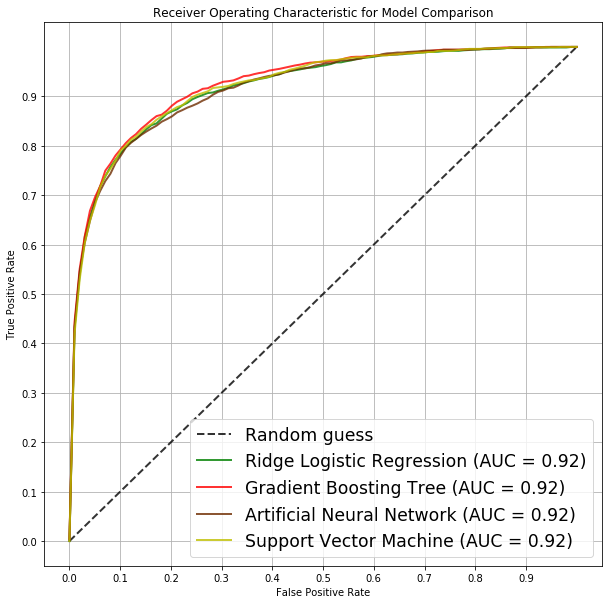

In [90]:
# baseline
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='#000000',
         label='Random guess', alpha=.8)

# Ridge Logistic Regression
plt.plot(fprs, tprs_lr, color='g',
         label=r'Ridge Logistic Regression (AUC = %0.2f)' % roc_auc_lr,
         lw=2, alpha=.8)

# Gradient Boosting Tree
plt.plot(fprs, tprs_gbdt, color='r',
         label=r'Gradient Boosting Tree (AUC = %0.2f)' % roc_auc_gbdt,
         lw=2, alpha=.8)

# Artificial Neural Network
plt.plot(fprs, tprs_nn, color='#6e2c00',
         label=r'Artificial Neural Network (AUC = %0.2f)' % roc_auc_nn,
         lw=2, alpha=.8)

# Support Vector Machine
plt.plot(fprs, tprs_svm, color='y',
         label=r'Support Vector Machine (AUC = %0.2f)' % roc_auc_svm,
         lw=2, alpha=.8)

plt.xlim([-0.05, 1.05])
plt.xticks(np.arange(0, 1, step=0.1))
plt.ylim([-0.05, 1.05])
plt.yticks(np.arange(0, 1, step=0.1))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Model Comparison')
plt.legend(loc="lower right", fontsize="xx-large")
plt.grid()
plt.show()

## Variable Importance Analysis

### Gradient Boosting Tree

In [95]:
pd.DataFrame(list(zip(names, gs_gbdt.best_estimator_.feature_importances_)), columns = ['var_name', 'importance_score']).sort_values(by = ["importance_score"], ascending = False).head()

,var_name,importance_score
62,PRCCS_216,0.534771
52,DXCCS_131,0.142956
54,DXCCS_107,0.049317
58,DXCCS_257,0.037332
53,DXCCS_249,0.033672


### Ridge Logistic Regression

In [96]:
pd.DataFrame(list(zip(names,gs_lr.best_estimator_.coef_[0])), columns = ['var_name', 'coef']).sort_values(by = ["coef"], ascending = False).head()

,var_name,coef
58,DXCCS_257,0.381136
52,DXCCS_131,0.357286
1,AGE,0.347684
62,PRCCS_216,0.269671
55,DXCCS_157,0.257805
